# Data Science Lab: Lab 7 part III (of III)

Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Lab: Fine Tuning and Transfer Learning

This assignment completes our segment on convolutional networks, computer vision and transfer learning. The goal of this colab notebook and lab is to get down the basics of Transfer learning, and harnessing the power of pre-trained notebooks, in a more substantial setting than CIFAR-10. Along the way, we get experience with creating and labeling data sets, and a number of other Python tools.

Specifically, we do the following:

* In this colab notebook, we create our own labeled image data set, with calls to the Bing API. We use this to download images with user-specified labels, into train and test directories.

* We preprocess all the images and use the directory names as lables to create our training and testing data sets.

* Then we download a pre-trained convolutional neural network from Pytorch. There is wide selection here. These have been trained on ImageNet. See references below.

* Then we add a new last layer, and train. Note that the last layer we add has to have the right size, namely, the number of classes in our data.

* Things to play with: Choosing different pre-trained models; Fine tuning the entire network vs freezing and fine tuning only the last layer or layers; Possibly adding more of our own layers at the end. (See the last optional problem at the end).


Some references:

The bing image downloader package from here https://pypi.org/project/bing-image-downloader/


# The following will allow us to call the Bing Image Downloader

In [1]:
!pip install bing-image-downloader



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import requests
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import random
import shutil

plt.ion()   # interactive mode


# Downloading the images we need

In [3]:
# These are the functions we need for asking for query terms, number of images
# and the fraction of train/test split
def get_query_terms():
    """Ask the user for a list of query terms."""
    queries = input("Enter query terms separated by commas: ").split(',')
    return [query.strip() for query in queries]


def get_positive_integers():
    """Ask the user for a list of positive integers."""
    while True:
        numbers = input("Enter positive integers corresponding to each query, separated by commas: ").split(',')
        try:
            # Convert string inputs to integers
            numbers = [int(num.strip()) for num in numbers]

            # Check if all numbers are positive
            if all(num > 0 for num in numbers):
                return numbers
            else:
                print("All numbers must be positive. Please try again.")
        except ValueError:
            print("Invalid input. Please enter integers only.")


def get_train_test_proportion():
    """Ask the user for a number between 0 and 1 and ensure it is in that range."""
    while True:
        try:
            # Ask the user for a number and try to convert it to a float
            num = float(input("What fraction of the data should be training? For example, enter 0.75 for 75 percent: "))

            # Check if the number is between 0 and 1 (inclusive)
            if 0 <= num <= 1:
                return num
            else:
                print("The number must be between 0 and 1. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 1.")

# Problem 0

Run the above code, and the code below, to make your own data set. Choose terms that aren't already one of the 1000 classes in the Imagenet dataset.

I recommend starting small: 2 or 3 different terms, and maybe 100-200 images max from each.

In [4]:
queries = get_query_terms()
# And the number of each
numbers = get_positive_integers()
# And the fraction of training data
frac_train = get_train_test_proportion()
# Check if number of queries matches number of positive integers
if len(queries) != len(numbers):
  print("Number of queries and integers do not match!")

for query, n in zip(queries, numbers):
    # Download all images to a common directory
    downloader.download(query, limit=n, output_dir='dataset/all_images', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)

    # Directory paths
    source_dir = f'dataset/all_images/{query}'
    train_dir = f'dataset/train/{query}'
    test_dir = f'dataset/test/{query}'

    # Create train and test directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all downloaded files
    all_files = [os.path.join(source_dir, f) for f in os.listdir(source_dir)]
    random.shuffle(all_files)  # Shuffle to randomize distribution

    # Determine split counts
    n_train = int(math.floor(len(all_files) * frac_train))
    train_files = all_files[:n_train]
    test_files = all_files[n_train:]

    # Move files to respective directories
    for f in train_files:
        shutil.move(f, train_dir)
    for f in test_files:
        shutil.move(f, test_dir)

    # Optionally, remove the source directory if it's now empty
    if not os.listdir(source_dir):
        os.rmdir(source_dir)


[%] Downloading Images to c:\Users\conne\OneDrive\Documents\ECE 460J\ECE460J-Assignments\Lab_7\dataset\all_images\electric scooter
[Error]Invalid image, not saving https://img.joomcdn.net/2b3e453fd15ce556872e473b1d5e5a9b7107694c_original.jpeg

[!] Issue getting: https://img.joomcdn.net/2b3e453fd15ce556872e473b1d5e5a9b7107694c_original.jpeg
[!] Error:: Invalid image, not saving https://img.joomcdn.net/2b3e453fd15ce556872e473b1d5e5a9b7107694c_original.jpeg

[!] Issue getting: https://trafficsafetyteam.org/wp-content/uploads/2023/04/FDOTD2-CTSP-E-Device-Safety-Tips.jpg
[!] Error:: Remote end closed connection without response
[!] Issue getting: https://bestescooterzone.com/wp-content/uploads/2021/09/10-Pros-and-Cons-of-E-scooter-3.jpeg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:997)>
[Error]Invalid image, not saving https://www.dudleydebosier.com/wp-content/uploads/2019/07/DDB_ContentMarketing_infographic_July19.j

# Let's make sure we downloaded enough of each

The code above is just making calls to the Bing API, and as you'll see there are a number of errors. So we should make sure that we have in fact downloaded the images we need. Print the number of files

In [5]:
import os

def count_files_in_directory(directory, prefix=""):
    """
    Recursively counts the number of files in each directory and subdirectory.

    Args:
    - directory: The directory path to start counting from.
    - prefix: A string used for indentation to visualize the folder structure.
    """
    num_files = sum([len(files) for r, d, files in os.walk(directory)])
    print(f"{prefix}{os.path.basename(directory)}: {num_files} files")

    for subdir in next(os.walk(directory))[1]:  # List subdirectories of the current directory
        path = os.path.join(directory, subdir)  # Full path of the subdirectory
        count_files_in_directory(path, prefix + "  ")  # Recursively count in this subdirectory

# Path to the dataset directory
dataset_dir = './dataset'

# Start the recursive count
count_files_in_directory(dataset_dir)


dataset: 600 files
  all_images: 0 files
  test: 150 files
    electric scooter: 50 files
    mochi: 50 files
    poutine: 50 files
  train: 450 files
    electric scooter: 150 files
    mochi: 150 files
    poutine: 150 files


# Preprocessing the data

Now that we've downloaded the data we want, we do some basic preprocessing with functions from Torchvision.

For the training data, we normalize and also use some data augmentation.

For the validation set, we just normalize.

# Problem 1 (Nothing to turn in)
Read about this here: https://pytorch.org/vision/stable/transforms.html

# Make dataloaders out of our training and testing data

In [6]:

# Data augmentation and normalization for training
# Just normalization for validation

# The directory that contains the data
data_dir = 'dataset'

# Now we apply the usual transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Problem 2
Write code that calls the dataloaders and displays some number of images, with their true labels.

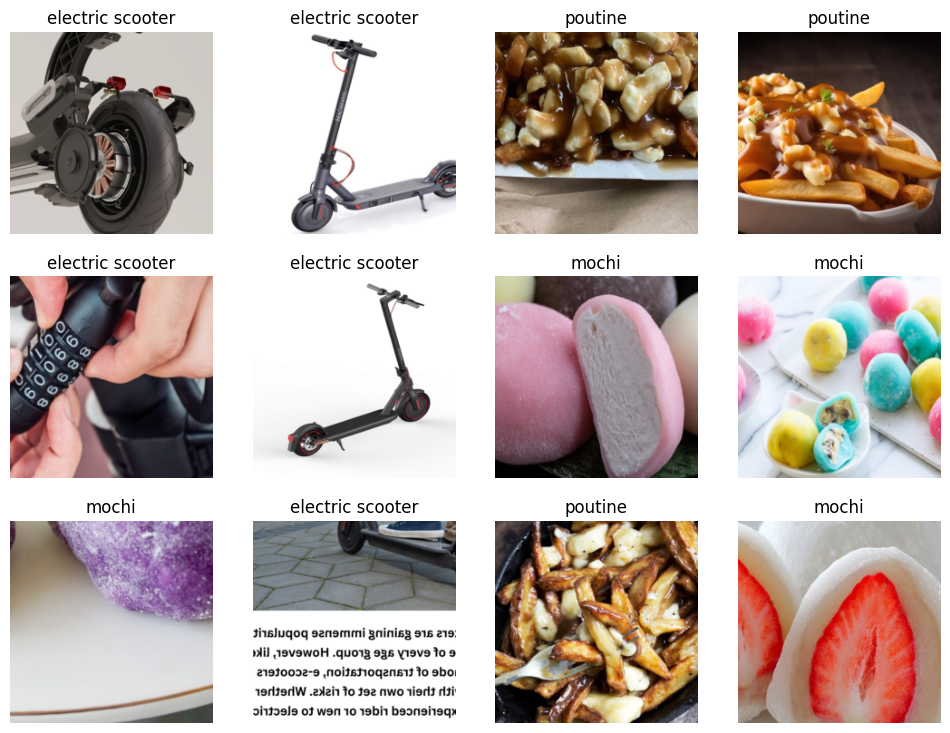

In [ ]:
# Display 12 varying images from the training set, along with their labels
inputs, labels = next(iter(torch.utils.data.DataLoader(image_datasets['train'], batch_size=12, shuffle=True)))

# Set up the plot, 3 rows, 4 columns
fig, axes = plt.subplots(3, 4, figsize=(12, 3 * 3))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Loop through each subplot and display images
for i, ax in enumerate(axes.flat):
    if i >= len(inputs):  # Skip empty slots in the grid
        break
    inp = inputs[i].numpy().transpose((1, 2, 0))  
    inp = std * inp + mean  # Denormalize
    inp = np.clip(inp, 0, 1)  # Clip values to valid range
    ax.imshow(inp)
    ax.set_title(class_names[labels[i]])
    ax.axis('off')
plt.show()

# Download a pre-trained model

We will now download a pretrained model that has been trained on Imagenet. I recomend starting with Resnet18. See here for other larger or smaller pre-trained modfels https://pytorch.org/vision/stable/models.html

In [12]:
# Now we load a pre-trained model, and replace the last layer with a non-initialized linear layer.

# This command loads a pre-trained model
model_ft = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\conne/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.87MB/s]


# Problem 3

Redefine the last layer of your neural network (called model_ft) to be a linear (fully connected layer) whose input size is whatever the input size is of the the current last layer, and whose output size is the number of labels your new data set has.

You need to figure out how to do this. It's not too difficult. You need will use similar commands as you used in the last 2 homeworks in order to define a linear layer. The key will be to find out what the last layer is called, and also to find out what is its input size, so that you can properly define the size of the last fully connected (linear) layer.

In [ ]:
# Last layer of models like ResNet is usually called fc, but still check for the name:
for name, param in model_ft.named_parameters():
    print(name, len(param)) # need name and param; name to know what the last layer is called, need param to find out what its input size is

conv1.weight 64
bn1.weight 64
bn1.bias 64
layer1.0.conv1.weight 64
layer1.0.bn1.weight 64
layer1.0.bn1.bias 64
layer1.0.conv2.weight 64
layer1.0.bn2.weight 64
layer1.0.bn2.bias 64
layer1.1.conv1.weight 64
layer1.1.bn1.weight 64
layer1.1.bn1.bias 64
layer1.1.conv2.weight 64
layer1.1.bn2.weight 64
layer1.1.bn2.bias 64
layer2.0.conv1.weight 128
layer2.0.bn1.weight 128
layer2.0.bn1.bias 128
layer2.0.conv2.weight 128
layer2.0.bn2.weight 128
layer2.0.bn2.bias 128
layer2.0.downsample.0.weight 128
layer2.0.downsample.1.weight 128
layer2.0.downsample.1.bias 128
layer2.1.conv1.weight 128
layer2.1.bn1.weight 128
layer2.1.bn1.bias 128
layer2.1.conv2.weight 128
layer2.1.bn2.weight 128
layer2.1.bn2.bias 128
layer3.0.conv1.weight 256
layer3.0.bn1.weight 256
layer3.0.bn1.bias 256
layer3.0.conv2.weight 256
layer3.0.bn2.weight 256
layer3.0.bn2.bias 256
layer3.0.downsample.0.weight 256
layer3.0.downsample.1.weight 256
layer3.0.downsample.1.bias 256
layer3.1.conv1.weight 256
layer3.1.bn1.weight 256
layer3

In [16]:
# From Lab 6:
# torch.nn.linear parameters: weight = input size of current last layer (layer 4 in this case), output size is number of labels new data set has, probably bias
linear = torch.nn.Sequential(
    torch.nn.Linear(512, len(class_names), bias=True)
)
# Last layer name is fc, so now redefine it to be linear (fully connected layer)
model_ft.fc = linear

# Training

* We are going to fine-tune by training all the layers.

* We can also freeze the old layers, and only update the last layers that we added. (This is not implemented below.)

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # updates the learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Parameters of the optimization

# Problem 4 (Optional)
Explore choosing different learning rates or optimizers to see how things go.

In [20]:
# We need to set the loss function, the optimizer, and the learning rate scheduler
criterion = nn.CrossEntropyLoss()
# though we're fine tuning, we're updating all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# the scheduler decreases the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

In [21]:
# Now we train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6795 Acc: 0.7267
test Loss: 0.0828 Acc: 0.9732

Epoch 1/24
----------
train Loss: 0.4732 Acc: 0.8178
test Loss: 0.1170 Acc: 0.9597

Epoch 2/24
----------
train Loss: 0.3723 Acc: 0.8689
test Loss: 0.1342 Acc: 0.9664

Epoch 3/24
----------
train Loss: 0.3278 Acc: 0.8622
test Loss: 0.0998 Acc: 0.9664

Epoch 4/24
----------
train Loss: 0.2604 Acc: 0.9000
test Loss: 0.0707 Acc: 0.9597

Epoch 5/24
----------
train Loss: 0.3047 Acc: 0.9133
test Loss: 0.0681 Acc: 0.9597

Epoch 6/24
----------
train Loss: 0.3934 Acc: 0.8689
test Loss: 0.0691 Acc: 0.9732

Epoch 7/24
----------
train Loss: 0.2032 Acc: 0.9222
test Loss: 0.0688 Acc: 0.9866

Epoch 8/24
----------
train Loss: 0.1985 Acc: 0.9444
test Loss: 0.0596 Acc: 0.9866

Epoch 9/24
----------
train Loss: 0.1875 Acc: 0.9356
test Loss: 0.0611 Acc: 0.9732

Epoch 10/24
----------
train Loss: 0.2212 Acc: 0.9333
test Loss: 0.0651 Acc: 0.9799

Epoch 11/24
----------
train Loss: 0.1808 Acc: 0.9489
test Loss: 0.0637 Acc

# Problem 5

Report your accuracy on the testing set. You should compute this explicitly by running all your testing examples through the model and checking them against their true labels.

In [ ]:
# Make method to test the model for convenience
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode, necessary for testing examples through the model
    running_loss = 0.0  # running loss of the model, for calculation later
    correct = 0         # number of correct predictions
    total_images = 0    # how many images actually tested

    # Use 'with' to iterate over test data
    with torch.no_grad():  
        for inputs, labels in dataloader:   # dataloader only contains test data
            inputs = inputs.to(device)
            labels = labels.to(device)
            total_images += labels.size(0)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)

    # Calculate total test loss
    test_loss = running_loss / dataset_sizes['test']
    # Calculate test accuracy
    test_acc = correct.double() / dataset_sizes['test']
    return test_loss, test_acc

# Evaluate the model, only pass in the test data (testing examples)
test_loss, test_acc = evaluate_model(model_ft, dataloaders['test'], criterion)
print('Accuracy on the testing set: {:.4f}'.format(test_acc))
print('Test loss: {:.4f}'.format(test_loss))

Accuracy on the testing set: 0.9866
Test loss: 0.0688


# Now let's visualize to see how well we did

# Problem 6

Print out images from the test set, reporting the predicted labels and the true labels.

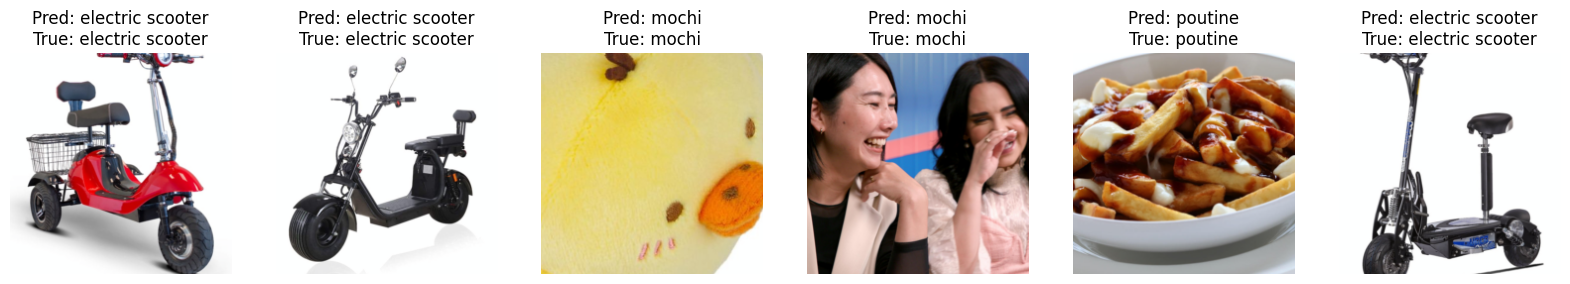

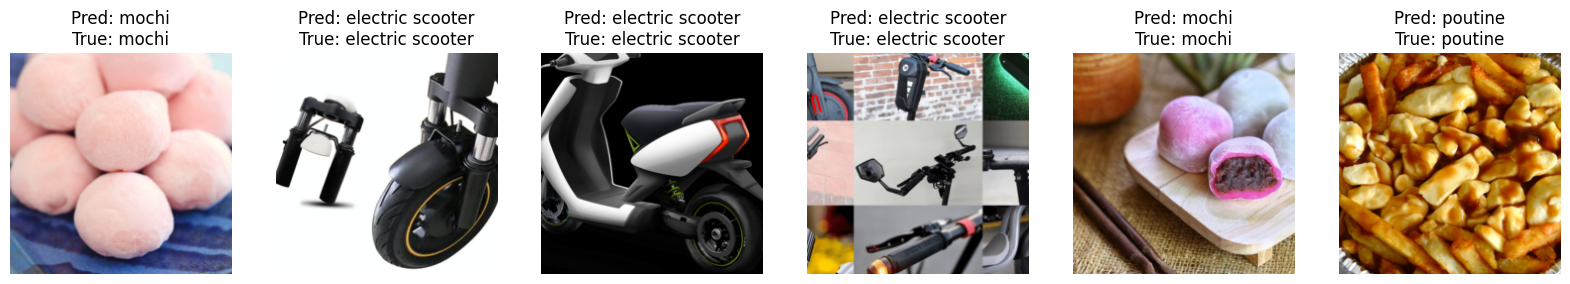

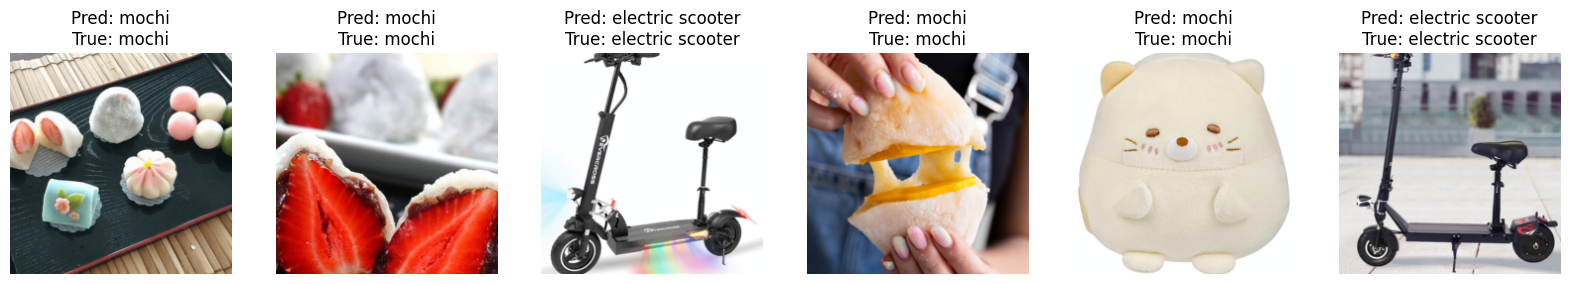

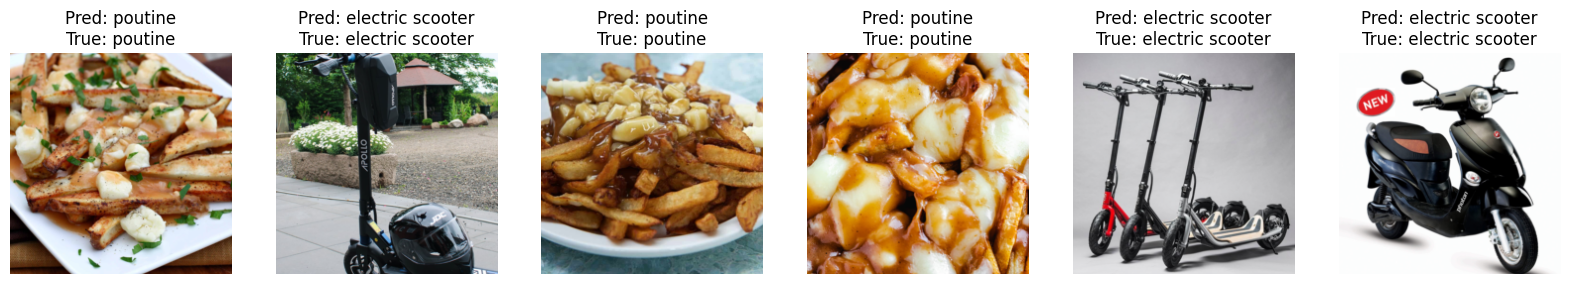

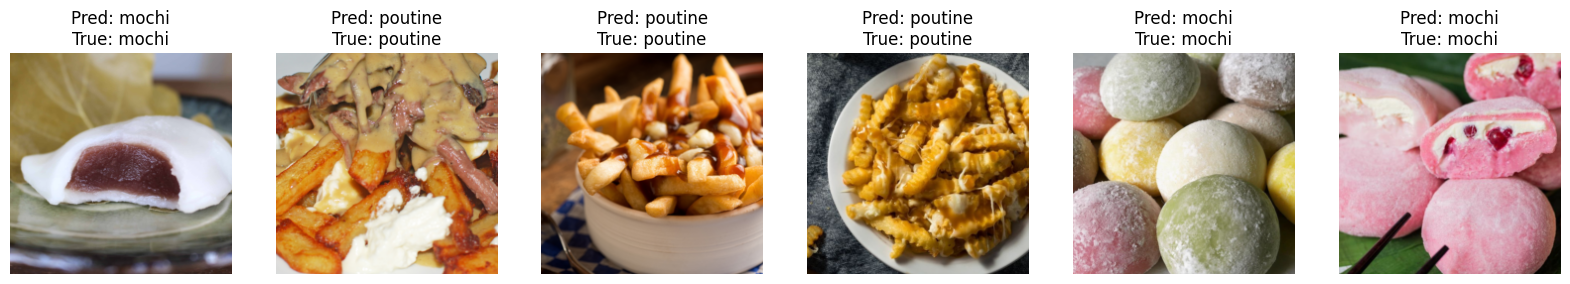

In [39]:
# Choose to display 30 images (5 rows x 6 columns)
def visualize_predictions(model, dataloader, class_names, num_images=30):
    model.eval()  # Set model to evaluation mode
    images_displayed = 0

    # Need to iterate over dataloader
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Prediction
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert inputs back to images
            inputs = inputs.cpu()
            labels = labels.cpu()
            preds = preds.cpu()

            # Display the images
            batch_size = len(inputs)
            for i in range(batch_size):
                # Check if there has been 30 images yet
                if images_displayed >= num_images:
                    break

                if images_displayed % 6 == 0:
                    if images_displayed > 0:
                        plt.show()
                    fig, axes = plt.subplots(1, 6, figsize=(20, 5))

                # Denormalize and display the image; calculating the mean and std are essential to making the image appear in its original form
                inp = inputs[i].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean  # Denormalize to make the image appear in original form
                inp = np.clip(inp, 0, 1)  # Use np.clip for appearance purposes

                ax = axes[images_displayed % 6]
                ax.imshow(inp)
                ax.set_title(f'Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}')  # For visualization, see what the prediction and true label are
                ax.axis('off')

                images_displayed += 1
            
            # Check if there has been 30 images yet
            if images_displayed >= num_images:
                break
        plt.show() 

# Call the function with the test data from DataLoader, since we are printing images from the test set
visualize_predictions(model_ft, dataloaders['test'], class_names, num_images=30)

# Problem 7 (Optional)

Experiment with some/all of the following:

* Play with different pre-trained models
* Experiment with different pre-processing of the data (e.g., turn data augmentation on or off).
* Experiment with adding more/fewer layers, and/or layers of different size.
* Fine tune by training everything or only the last (new) layer -- this requires figuring out how to only update some of the layers.
* Try to reduce the number of images you use for training. How few can you use and still get good accuracy? Remember that you were all able to learn what a Goblin shark is with only one single example.